# Section F Logistic Regression vs. Bayesian Classifier

### Question 7. Discriminative vs Generative Models

### 1.Loading Dataset

In [1]:
## Libraries:
library(mvtnorm) # generates multivariate Gaussian sampels and calculate the densities
library(ggplot2)
library(reshape2)

In [21]:
train.data.csv<- read.csv("Task1E_train.csv", header = TRUE)
test.data.csv <- read.csv("Task1E_test.csv", header = TRUE)

In [37]:
train.data<-train.data.csv[,-3]
train.label<-train.data.csv[,3]
head(train.data)

x1,x2
-0.4367052,3.171451
5.1048972,1.227815
3.9974518,1.049502
2.5354540,1.242902
4.2624556,2.551909
1.5505866,2.595164


In [38]:
test.data<-test.data.csv[,-3]
test.label<-test.data.csv[,3]
head(test.data)

x1,x2
3.4781571,-0.51546992
4.8959781,0.95320554
-0.5783557,5.44553527
3.8417831,0.65759443
2.2649154,4.18082840
3.8550566,-0.08328894


In [24]:
# Class means:
mu0.hat <- colMeans(train.data[train.label==-1,])
mu1.hat <- colMeans(train.data[train.label==1,])

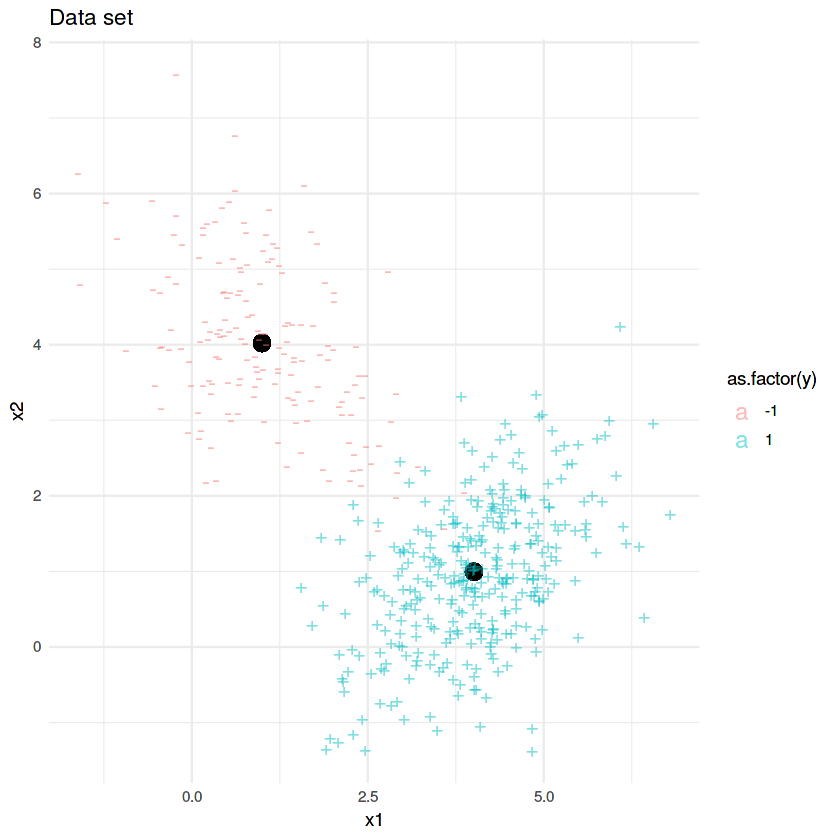

In [30]:
## Take a look at the data set
ggplot(data=train.data.csv, aes(x=x1, y=x2, color=as.factor(y), label=ifelse(y=='1', '+', '-'))) +
    geom_point(x=mu0.hat[1], y=mu0.hat[2], size=4, color = 'black') +
    geom_point(x=mu1.hat[1], y=mu1.hat[2], size=4, color = 'black') +
    geom_text(size = 5, alpha=0.5) +
    ggtitle ('Data set') +
    theme_minimal()

In [31]:
# auxiliary function that predicts class labels
predict <- function(w, X, c0, c1){
    sig <- sigmoid(w, X)
    return(ifelse(sig>0.5, c1,c0))
}
    
# auxiliary function that calculate a cost function
cost <- function (w, X, T, c0){
    sig <- sigmoid(w, X)
    return(sum(ifelse(T==c0, 1-sig, sig)))
}


# Sigmoid function (=p(C1|X))
sigmoid <- function(w, x){
    return(1.0/(1.0+exp(-w%*%t(cbind(1,x)))))    
}

In [32]:
train.length <- dim(train.data)[1]

# for datasets increase of 5 point at  a time
set.length <- length(seq(5,train.length,5))

test.error = data.frame(matrix(0, nrow = set.length*2, ncol = 3))

names(test.error) <- c('model_type', 'set_size','error')

test.error$model_type <- rep(c("Bayesian", "Logistic"), each = set.length)
test.error$set_size <- rep(seq(5,train.length,5), each = 1)

tau <- 1 # iteration counter
eta <- 0.01 # learning rate

In [33]:
#Implementation of Bayes classifier

for(set.size in seq(5,train.length,5)){
    #print(set.size)
    sample.index <- sample(train.length, set.size, replace = FALSE)
    
    train.data.subset <- train.data[sample.index,]
    train.label.subset <- train.label[sample.index]
    
    ###Bayesian classifier
    
    # Class probabilities:
    p0.hat <- sum(train.label.subset==-1)/nrow(train.data.subset) # total number of samples in class 0 divided by the total nmber of training data
    p1.hat <- sum(train.label.subset==1)/nrow(train.data.subset) # or simply 1 - p1.hat
    
    mu0.hat <- colMeans(train.data.subset[train.label.subset==-1,])
    mu1.hat <- colMeans(train.data.subset[train.label.subset==1,])
    
    sigma0.hat <- var(train.data.subset[train.label.subset==1,])
    sigma1.hat <- var(train.data.subset[train.label.subset==-1,])

    # shared covariance matrix:
    sigma.hat <- p0.hat * sigma0.hat + p1.hat * sigma1.hat
    
    # calculate posteriors:
    posterior0 <- p0.hat*dmvnorm(x=train.data.subset, mean=mu0.hat, sigma=sigma.hat)
    posterior1 <- p1.hat*dmvnorm(x=train.data.subset, mean=mu1.hat, sigma=sigma.hat)
    
    # calculate predictions:
    train.predict <- ifelse(posterior0 > posterior1, -1, 1)
    test.predict <- ifelse(p0.hat*dmvnorm(x=test.data, mean=mu0.hat, sigma=sigma.hat) > p1.hat*dmvnorm(x=test.data, mean=mu1.hat, sigma=sigma.hat), -1, 1)

    # calculate error:
    test.error[test.error$model_type == 'Bayesian' & test.error$set_size == set.size, 'error'] = sum(test.label!=test.predict)/nrow(test.data)*100
    
    
    ###Bayesian classifier ends
    
    #Implementation of Logistic regression classifier
    
    ### Logistic regression starts
    
    X <- as.matrix(train.data.subset)
    
    X.test <- as.matrix(test.data)
    T <- ifelse(train.label.subset == -1,0,1)
    W <- matrix(,nrow=set.size+1, ncol=(ncol(X)+1))
    W[1,] <- runif(ncol(W))
    
    for (i in 1:set.size){

        Y <- sigmoid(W[i,],X)
        W[(i+1),] <- W[i,] - eta * (Y[i]-T[i]) * cbind(1, t(X[i,]))
    
    }
    test.error[test.error$model_type == 'Logistic' & test.error$set_size == set.size, 'error'] = sum(predict(W[set.size+1,],X.test, -1, 1)!=test.label)/nrow(test.data)*100
    ### Logistic regression ends 
}

In [34]:
test.error.m <-melt(test.error[,], id=c('error', 'set_size'))

### 2. Plot the error for the Logistic and Bayesian Vs Set Size

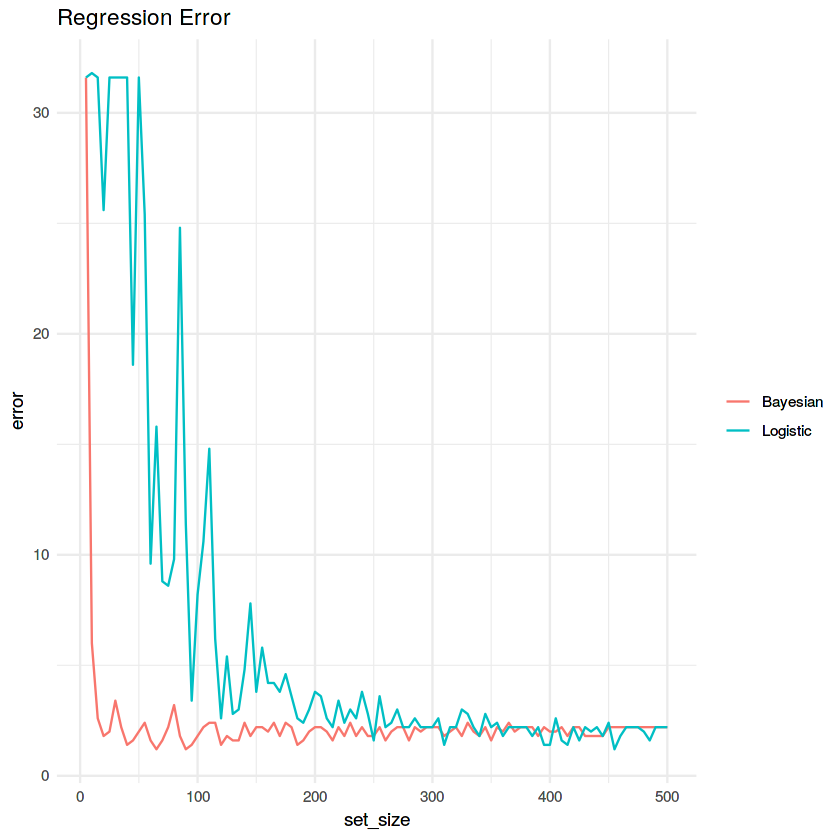

In [36]:
# plot to show the regression error of bayesian and logistic VS set size.
ggplot(data=test.error.m, aes(x=set_size, y=error, color=value)) + geom_line() +
       scale_color_discrete(guide = guide_legend(title = NULL)) + theme_minimal() +
       ggtitle("Regression Error")

### 4. Observation:

1. When the training data points are incresed:
    * Bayesian Classifier : It converges very fastly to low error and after that kind of stagnant at a level with a bit of fluctuation.
    * Logistic : There is a lot of uncertinitiy in logistic following a zig- zag pattern but eventually after a significant increase in the training data point it as at the same level of bayesian and sometimes even lower than bayesian.

2.  A) When the training set is small:
       * Bayesian Classifier is better as it converges fastly to low test error.
       
2.  B) When the training set is big:
       * Both of the classifier will be suitable for the large dataset as both of them performs well on large dataset.
       
3. Bayesian Classifier : By calculation it learns about the parameters and once it has the value of the parameter it starts performing well and does'nt change much with the respect to the data.

4. Logistic Classifier: It tries to minimize the loss function by changing the parameters and it depends upon the learning rate value that is the reason it takes more time because there it keeps on adjusting its parameter.